### Data transformation

In [3]:
# dataset 호출 이전에 resizing을 위한 transformation 객체 생성
from torchvision import transforms

# transformation 정의하기
data_transform = transforms.Compose([
    transforms.Resize((32, 32)), transforms.ToTensor(),
])

### Data download

In [4]:
# MNIST dataset 호출
from torchvision import datasets, transforms
path = "/Users/chan/Desktop/jupyter/dataset/"

# trainset 불러오기
train_data = datasets.MNIST(path, train=True, download=True, transform=data_transform)

# testset 불러오기
test_data = datasets.MNIST(path, train=False, download=True, transform=data_transform)

100%|██████████| 9912422/9912422 [00:00<00:00, 14450034.41it/s]


Extracting /Users/chan/Desktop/jupyter/dataset/MNIST/raw/train-images-idx3-ubyte.gz to /Users/chan/Desktop/jupyter/dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28073161.95it/s]


Extracting /Users/chan/Desktop/jupyter/dataset/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/chan/Desktop/jupyter/dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6927154.95it/s]


Extracting /Users/chan/Desktop/jupyter/dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/chan/Desktop/jupyter/dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14953319.28it/s]

Extracting /Users/chan/Desktop/jupyter/dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/chan/Desktop/jupyter/dataset/MNIST/raw



### Data 전처리

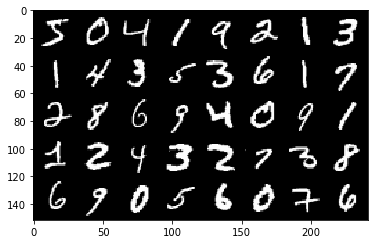

In [45]:
# sample image 확인
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# training data 분리 
x_train, y_train = train_data.data, train_data.targets

# test data 분리
x_test, y_test = test_data.data, test_data.targets

# (image, Height, width) => (image, channel, height, width)로 변환
if len(x_train.shape) == 3 :
    x_train = x_train.unsqueeze(1)

if len(x_test.shape) == 3 :
    x_test = x_test.unsqueeze(1)

# tensor => image로 변환하여 보여주는 함수 정의

def show(img):
    # tensor image를 numpy 형태로 변환
    np_img = img.numpy()
    # (channel, height, width) 를 (height, width, channel로) 변경
    np_img_trans = np_img.transpose((1,2,0))
    plt.imshow(np_img_trans, interpolation="nearest")

# image grid를 생성하고 출력
# 총 40개 이미지, 한 행당 8개 이미지 출력
x_grid = utils.make_grid(x_train[:40], nrow=8)

show(x_grid)

In [63]:
# 다운받은 dataset을 DataLoader로 불러내기
from torch.utils.data import DataLoader

train_set = DataLoader(train_data, batch_size = 32, shuffle=True)
test_set = DataLoader(test_data, batch_size = 32)

### LeNet 구현

In [48]:
from torch import nn
import torch.nn.functional as F

class LeNet_5(nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv2(x))
        x = F.avg_pool2d(x, 2, 2)
        x = F.tanh(self.conv3(x))
        x = x.view(-1, 120) 
        x = F.tanh(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)

        return x

model = LeNet_5()
print(model)

LeNet_5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)


In [73]:
import torch
# 모델 mps로 전달
device = torch.device('cuda')
model.to(device)
print(next(model.parameters()).device)

AssertionError: Torch not compiled with CUDA enabled

In [72]:
from torchsummary import summary
summary(model, input_size=(1, 32, 32))

RuntimeError: Input type (torch.FloatTensor) and weight type (MPSFloatType) should be the same or input should be a MKLDNN tensor and weight is a dense tensor